In [1]:
# Stanisław Wilczyński project1
import sys
from time import time

import numpy as np

%pylab inline
from __future__ import print_function
STEPS = 2 * 10**3
INDEPENDENT = 'independent'
SAME_CORR = 'same_corr'
AUTO_CORR = 'auto_corr'
GD = 'gd'
SGD = 'sgd'
SAGA = 'saga'
SVRG = 'svrg'

Populating the interactive namespace from numpy and matplotlib


In [28]:
def loss(a, x, y):
    xb = np.dot(x, a)
    return np.sum(np.log(1 + np.exp(xb)) - np.multiply(y, xb))


def generate_data(n, d, ro, option, debug=False):
    mean = np.zeros(d)
    if option == INDEPENDENT:
        cov = np.identity(d)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == SAME_CORR:
        cov = np.ones((d, d)) * ro + np.identity(d) * (1 - ro)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == AUTO_CORR:
        cov = [[ro ** np.abs(i - j) for i in range(d)] for j in range(d)]
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)

    raise Exception('Wrong option')


def generate_response(X, beta, debug=False):
    p = np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))
    if debug:
        print('Probability\n', p)
    return np.random.binomial(1, p).reshape(-1, 1)


# proximal for lambda penalty - as in the lecture
def proximal(a, step, lam):
    d = a.shape[0]
    return np.multiply(np.sign(a), np.maximum((np.abs(a) - lam * step), np.zeros((d, 1))))


# gradient step for logistic regression model - as in project
def grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    grad_a = np.dot(x.T, (p - y))
    return a - step * grad_a


# stochastic gradient step - calculate gradient with respect only to loss connected with randomly chosen x_j
def stochastic_grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    j = np.random.randint(n)
    p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
    grad_a = (p - y[j]) * x[j, :]
    return a - step * grad_a.reshape(-1, 1)


# gradient descent algorithm
def gradient_descent(x, y, epsilon=0.0001, step=0.01, lam=0.01, prox=False, stochastic=False):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        losses += [loss(a, x, y)]
        if stochastic:
            a = stochastic_grad_step(a, x, y, step)
        else:
            a = grad_step(a, x, y, step)
        if prox:
            a = proximal(a, step, lam)
        steps += 1
        prev_loss = curr_loss
        curr_loss = loss(a, x, y)
    return a, losses, steps


# saga algorithm
def saga(x, y, epsilon=0.0001, step=0.01, lam=0.01, prox=False):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    M = np.multiply(p - y, x)
    avg = np.mean(M, axis=0)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        losses += [loss(a, x, y)]
        ####saga step
        j = np.random.randint(n)
        old_deriv = np.array(M[j, :])  # very important copy
        p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
        new_deriv = (p - y[j]) * x[j, :]
        M[j, :] = new_deriv
        a -= step * ((new_deriv - old_deriv + avg).reshape(-1, 1))
        avg += (new_deriv - old_deriv) / n
        if prox:
            a = proximal(a, step, lam)
        ####
        steps += 1
        prev_loss = curr_loss
        curr_loss = loss(a, x, y)
    return a, losses, steps


# svrg algorithm
def svrg(x, y, epsilon=0.0001, step=0.01, lam=0.01, prox=False, T=100):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    # svrg outer loop
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        a_avg = np.array(a)
        p = np.exp(np.dot(x, a_avg)) / (1 + np.exp(np.dot(x, a_avg))).reshape(n, 1)
        grad_avg = np.mean(np.multiply(p - y, x), axis=0)
        # svrg inner loop
        for _ in range(T):
            losses += [loss(a, x, y)]
            steps += 1
            j = np.random.randint(n)
            p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
            p_avg = np.exp(np.dot(x[j, :], a_avg)) / (1 + np.exp(np.dot(x[j, :], a_avg))).ravel()[0]
            deriv = (p - y[j]) * x[j, :]
            deriv_avg = (p_avg - y[j]) * x[j, :]
            a -= step * ((deriv - deriv_avg + grad_avg).reshape(-1, 1))
            if prox:
                a = proximal(a, step, lam)
            prev_loss = curr_loss
            curr_loss = loss(a, x, y)
    return a, losses, steps


In [44]:
def perform_simulation(n, d, eps, data_generation, step_sizes, lambdas, is_prox=False, start_ind=1):
    print('The data dimensions are n = {} and d = {} and precision = {}'.format(n, d, eps))
    beta = np.random.uniform(-1, 2, d).reshape(-1, 1)  # very important reshape
    if is_prox:
        print('87.5% of betas are set to zero')
        ind = np.random.permutation(np.arange(d))[:-d//8]
        beta[ind] = 0
    if len(lambdas):
        lambdas = [0,0,0,0]
    print('---------------------------------------------------------------')
    x = generate_data(n, d, 0.9, data_generation)
    y = generate_response(x, beta)
    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, step=step_sizes[0], lam=lambdas[0], prox=is_prox)
    t2 = time()
    print('Gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for GD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for GD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, stochastic=True, step=step_sizes[1], lam=lambdas[1], prox=is_prox)
    t2 = time()
    print('Stochastic gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SGD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SGD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = saga(x, y, step=step_sizes[2], lam=lambdas[2], prox=is_prox)
    t2 = time()
    print('SAGA took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SAGA: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SAGA')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = svrg(x, y, step=step_sizes[3], lam=lambdas[3], prox=is_prox)
    t2 = time()
    print('SVRG took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SVRG: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SVRG')

    plt.legend()
    plt.show()

In [56]:
#dobrac step_size i lambdy dla jednego rozmiaru danych ale wszystkich typow inicjalizacji,
#potem czas bedziemy mierzyc juz bez patrzenia na wyniki i bez wzgledu na lambdy,step_size
STEPS = 10**4
def find_best_parameters(n,d, data_generation, f_type, steps, lambdas, is_prox=False, plot_losses=False, debug=False):
    start_ind=2
    beta = np.random.uniform(-1, 2, d).reshape(-1, 1)  # very important reshape
    if is_prox:
        ind = np.random.permutation(np.arange(d))[:-d//8]
        beta[ind] = 0
    x = generate_data(n, d, 0.9, data_generation)
    y = generate_response(x, beta)
    best_score = sys.maxsize
    best_step = 0
    best_lam = 0
    best_losses = []
    if len(lambdas)==0:
        lambdas = [0]
    for lam in lambdas:
        for step in steps:
            if debug:
                print('Testing for {} step={} and lam={}. Use proximal: {}'.format(f_type, step, lam, is_prox))
            if f_type == GD:
                a, losses, steps_count = gradient_descent(x, y, step=step, lam=lam, prox=is_prox)
            elif f_type == SGD:
                a, losses, steps_count = gradient_descent(x, y, stochastic=True, step=step, lam=lam, prox=is_prox)
            elif f_type == SAGA:
                a, losses, steps_count = saga(x, y, step=step, lam=lam, prox=is_prox)
            elif f_type == SVRG:
                a, losses, steps_count = svrg(x, y, step=step, lam=lam, prox=is_prox)
            if losses[-1] < best_score:
                if debug:
                    print("It's better. Previous loss {}, current loss {}".format(best_score, losses[-1]))
                best_step = step
                best_lam = lam
                best_score = losses[-1]
                best_losses = np.array(losses)
    if plot_losses:
        plt.figure(1)
        plt.plot(np.arange(len(best_losses[start_ind:])), best_losses[start_ind:], label='Loss for {}'.format(f_type))
        plt.legend()
        plt.show()
    return best_step, best_lam

In [37]:
dictionary_nonzero = {}
n = 5*10**3
d = 10
STEPS = 5*10**3
for method in [INDEPENDENT, SAME_CORR, AUTO_CORR]:
    for f in [GD, SGD, SAGA, SVRG]:
        step, lam = find_best_parameters(n, d, method, f, 10**np.linspace(-6,-2,15), [], False, plot_losses=False)
        dictionary_nonzero[(f,method)]=(step,lam)
        print('Best parameters for {} in settings {} is gamma={}'.format(f,method,step))

steps_ind = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==INDEPENDENT}
steps_auto = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==AUTO_CORR}
steps_same = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==SAME_CORR}
print(steps_ind)
print(steps_auto)
print(steps_same)

/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide


Best parameters for gd in settings independent is gamma=0.000138949549437
Best parameters for sgd in settings independent is gamma=0.0193069772888
Best parameters for saga in settings independent is gamma=0.00848342898244
Best parameters for svrg in settings independent is gamma=0.1
Best parameters for gd in settings same_corr is gamma=0.000138949549437
Best parameters for sgd in settings same_corr is gamma=0.0439397056076
Best parameters for saga in settings same_corr is gamma=0.1
Best parameters for svrg in settings same_corr is gamma=0.1
Best parameters for gd in settings auto_corr is gamma=0.000719685673001
Best parameters for sgd in settings auto_corr is gamma=0.1
Best parameters for saga in settings auto_corr is gamma=0.0439397056076
Best parameters for svrg in settings auto_corr is gamma=0.1


The data dimensions are n = 5000 and d = 10 and precision = 0.0001
---------------------------------------------------------------
Gradient descent took 2.07451295853 seconds and performed 1250 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0139398660218
Steps count for GD: 1250
The loss was 1483.01943503
---------------------------------------------------------------
Stochastic gradient descent took 2.1065299511 seconds and performed 1713 steps
Number of nonzero coeff: 10
Squared error for betas: 0.959643097501
Steps count for SGD: 1713
The loss was 1549.77878226
---------------------------------------------------------------
SAGA took 4.57787799835 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 1.04260091449
Steps count for SAGA: 5000
The loss was 1544.84737361
---------------------------------------------------------------
SVRG took 2.03840088844 seconds and performed 2500 steps
Number of nonzero coeff: 10
Squared error for betas:

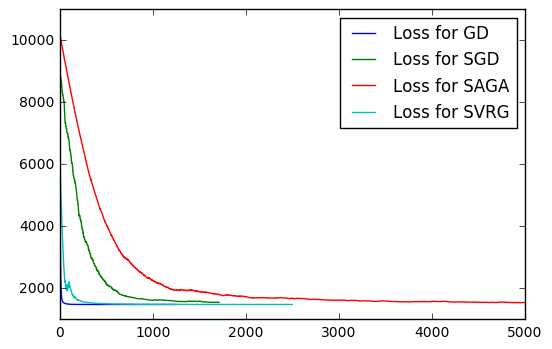

In [39]:
curr_steps = [steps_ind[GD], steps_ind[SGD], steps_ind[SAGA], steps_ind[SVRG]]
perform_simulation(n,d, 10**(-4), INDEPENDENT, curr_steps, [], is_prox=False)

The data dimensions are n = 5000 and d = 10 and precision = 0.0001
---------------------------------------------------------------
Gradient descent took 1.43671822548 seconds and performed 1250 steps
Number of nonzero coeff: 10
Squared error for betas: 0.122502632569
Steps count for GD: 1250
The loss was 1683.08028739
---------------------------------------------------------------
Stochastic gradient descent took 1.29598593712 seconds and performed 1565 steps
Number of nonzero coeff: 10
Squared error for betas: 0.568756899543
Steps count for SGD: 1565
The loss was 1720.81204909
---------------------------------------------------------------
SAGA took 3.99495601654 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.930472877888
Steps count for SAGA: 5000
The loss was 1716.92231846
---------------------------------------------------------------
SVRG took 2.3776409626 seconds and performed 2800 steps
Number of nonzero coeff: 10
Squared error for betas:

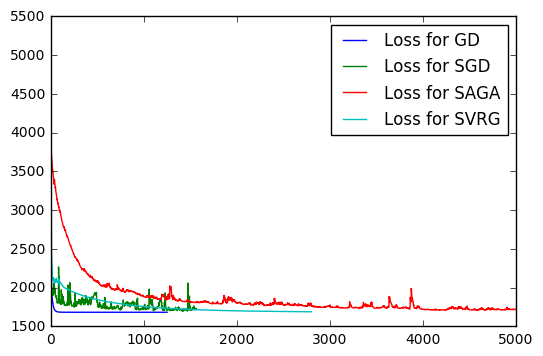

In [40]:
curr_steps = [steps_auto[GD], steps_auto[SGD], steps_auto[SAGA], steps_auto[SVRG]]
perform_simulation(n,d, 10**(-4), AUTO_CORR, curr_steps, [], is_prox=False)

The data dimensions are n = 5000 and d = 10 and precision = 0.0001
---------------------------------------------------------------
Gradient descent took 1.39377188683 seconds and performed 1250 steps
Number of nonzero coeff: 10
Squared error for betas: 0.821840696445
Steps count for GD: 1250
The loss was 1144.70447016
---------------------------------------------------------------
Stochastic gradient descent took 0.966135978699 seconds and performed 1266 steps
Number of nonzero coeff: 10
Squared error for betas: 6.82656247213
Steps count for SGD: 1266
The loss was 1317.67954007
---------------------------------------------------------------
SAGA took 3.95274996758 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 4.77224522308
Steps count for SAGA: 5000
The loss was 1217.22785118
---------------------------------------------------------------
SVRG took 3.8053548336 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 

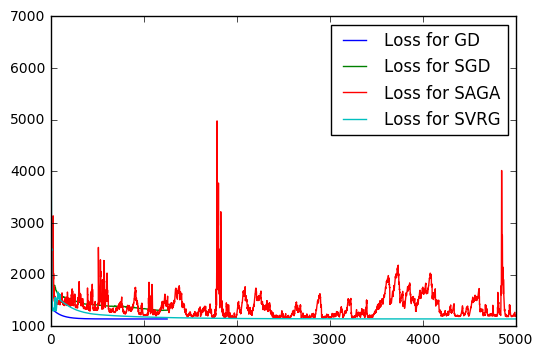

In [41]:
curr_steps = [steps_same[GD], steps_same[SGD], steps_same[SAGA], steps_same[SVRG]]
perform_simulation(n,d, 10**(-4), SAME_CORR, curr_steps, [], is_prox=False)

In [59]:
dictionary_zero = {}
n = 5*10**3
d = 10
STEPS = 5*10**3
for method in [INDEPENDENT, SAME_CORR, AUTO_CORR]:
    for f in [GD, SGD, SAGA, SVRG]:
        step, lam = find_best_parameters(n, d, method, f, 10**np.linspace(-6,-2,5), 10**np.linspace(-4,1,5), is_prox=True, plot_losses=False)
        dictionary_zero[(f,method)]=(step,lam)
        print('Best parameters for {} in settings {} is gamma={} and lambda={}'.format(f,method,step,lam))

steps_ind = {x[0][0]:x[1][0] for x in dictionary_zero.items() if x[0][1]==INDEPENDENT}
steps_auto = {x[0][0]:x[1][0] for x in dictionary_zero.items() if x[0][1]==AUTO_CORR}
steps_same = {x[0][0]:x[1][0] for x in dictionary_zero.items() if x[0][1]==SAME_CORR}
lam_ind = {x[0][0]:x[1][1] for x in dictionary_zero.items() if x[0][1]==INDEPENDENT}
lam_auto = {x[0][0]:x[1][1] for x in dictionary_zero.items() if x[0][1]==AUTO_CORR}
lam_same = {x[0][0]:x[1][1] for x in dictionary_zero.items() if x[0][1]==SAME_CORR}

curr_steps = [steps_ind[GD], steps_ind[SGD], steps_ind[SAGA], steps_ind[SVRG]]
curr_lambdas = [lam_ind[GD], lam_ind[SGD], lam_ind[SAGA], lam_ind[SVRG]]



Best parameters for gd in settings independent is gamma=0.001 and lambda=0.0001
Best parameters for sgd in settings independent is gamma=0.01 and lambda=0.00177827941004
Best parameters for saga in settings independent is gamma=0.01 and lambda=0.0001
Best parameters for svrg in settings independent is gamma=0.01 and lambda=0.0001


/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide


Best parameters for gd in settings same_corr is gamma=0.001 and lambda=0.0001
Best parameters for sgd in settings same_corr is gamma=0.01 and lambda=0.0316227766017
Best parameters for saga in settings same_corr is gamma=0.01 and lambda=0.0316227766017
Best parameters for svrg in settings same_corr is gamma=0.01 and lambda=0.0316227766017
Best parameters for gd in settings auto_corr is gamma=0.0001 and lambda=0.00177827941004
Best parameters for sgd in settings auto_corr is gamma=0.01 and lambda=0.0001
Best parameters for saga in settings auto_corr is gamma=0.01 and lambda=0.00177827941004
Best parameters for svrg in settings auto_corr is gamma=0.01 and lambda=0.0316227766017


The data dimensions are n = 5000 and d = 10 and precision = 0.0001
---------------------------------------------------------------
Gradient descent took 1.56489300728 seconds and performed 1250 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0369444334209
Steps count for GD: 1250
The loss was 1705.83135262
---------------------------------------------------------------
Stochastic gradient descent took 1.2273209095 seconds and performed 1378 steps
Number of nonzero coeff: 10
Squared error for betas: 1.36712185789
Steps count for SGD: 1378
The loss was 2022.67059515
---------------------------------------------------------------
SAGA took 4.7865011692 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.111002018404
Steps count for SAGA: 5000
The loss was 1733.89321013
---------------------------------------------------------------
SVRG took 4.69499087334 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 

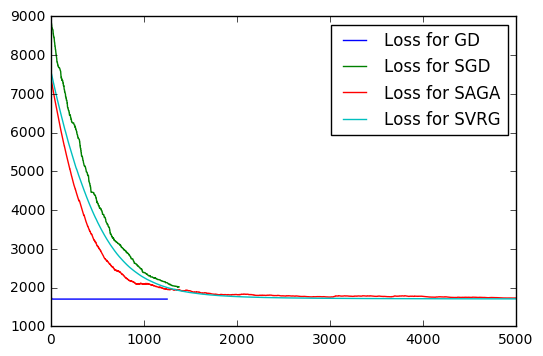

In [60]:
perform_simulation(n,d, 10**(-4), INDEPENDENT, curr_steps, curr_lambdas, is_prox=False)